<a href="https://colab.research.google.com/github/ShreyaSutar2004/Cancer_prediction_model/blob/main/Medical_Images_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import torch
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim


In [ ]:
!pip install tensorflow

In [19]:
# ON GPU
if torch.cuda.is_available():
  device=torch.device('cuda')
else:
  device=torch.device('cpu')

print(device)

cuda


In [ ]:
!pip install kaggle

In [2]:
# Loading dataset
credentials=json.load(open('/content/kaggle (1).json'))
credentials

{'username': 'shreyasutar2004', 'key': '9387f69c10e2cce115fe5555b526e0d7'}

In [3]:
os.environ['KAGGLE_USERNAME']=credentials['username']
os.environ['KAGGLE_KEY']=credentials['key']

In [ ]:
# Downloading the dataset
!kaggle datasets download -d andrewmvd/medical-mnist

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/medical-mnist
License(s): other
medical-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip '/content/medical-mnist.zip'

Archive:  /content/medical-mnist.zip
replace AbdomenCT/000000.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
# Converting into dataFrame

image_data=['/content/AbdomenCT', '/content/BreastMRI', '/content/CXR', '/content/ChestCT', '/content/Hand', '/content/HeadCT' ]
categories=['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

data=[]

for category, images in zip(categories, image_data):
 for filename in os.listdir(images):
  image_path=os.path.join(images,filename)
  data.append([image_path, category])

df=pd.DataFrame(data, columns=['image_path', 'category'])
df






,image_path,category
0,/content/AbdomenCT/003023.jpeg,AbdomenCT
1,/content/AbdomenCT/004884.jpeg,AbdomenCT
2,/content/AbdomenCT/005793.jpeg,AbdomenCT
3,/content/AbdomenCT/009770.jpeg,AbdomenCT
4,/content/AbdomenCT/007939.jpeg,AbdomenCT
...,...,...
58949,/content/HeadCT/005500.jpeg,HeadCT
58950,/content/HeadCT/005462.jpeg,HeadCT
58951,/content/HeadCT/006560.jpeg,HeadCT
58952,/content/HeadCT/009032.jpeg,HeadCT


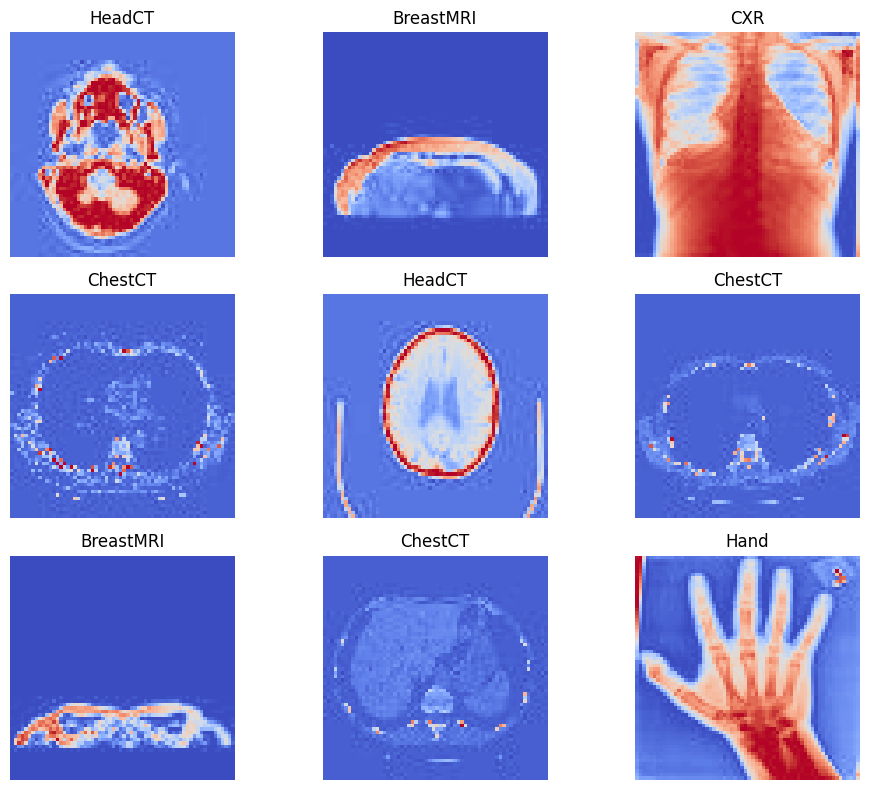

In [6]:
# Visualization of image dataset
plt.figure(figsize=(10,8))
for idx, (_, row) in enumerate(df.sample(9).iterrows()):
    img = plt.imread(row['image_path'])
    plt.subplot(3,3,idx+1)
    plt.imshow(img, cmap='coolwarm')
    plt.title(row['category'])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
df['category'].value_counts()

,count
category,
AbdomenCT,10000
CXR,10000
Hand,10000
ChestCT,10000
HeadCT,10000
BreastMRI,8954


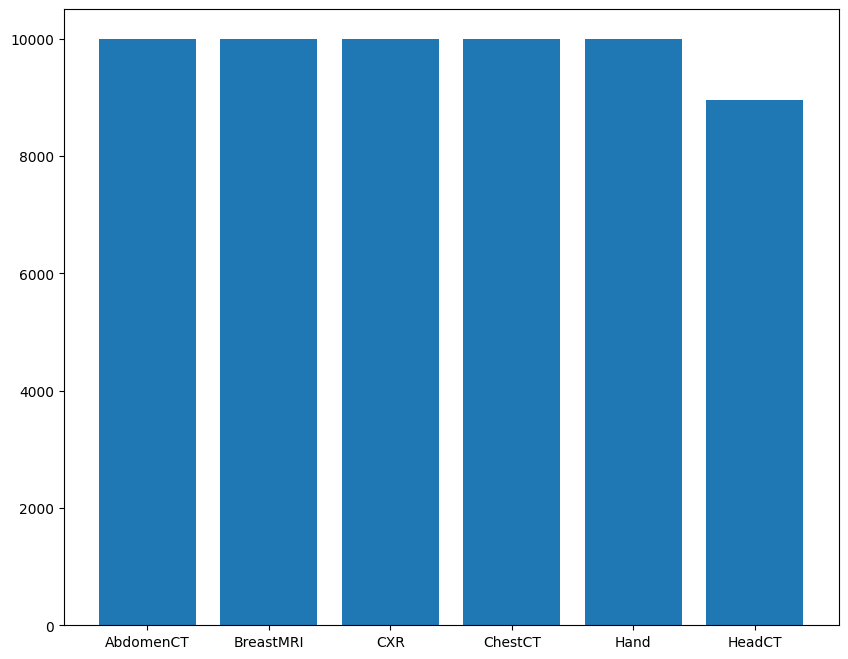

In [8]:
# Df on plot
plt.figure(figsize=(10,8))
categories = df['category'].unique()
counts = df['category'].value_counts()
plt.bar(categories, counts)
plt.show()

In [9]:
# Using Label Encoders
encoder=LabelEncoder()
df['category']= encoder.fit_transform(df['category'])
df

,image_path,category
0,/content/AbdomenCT/003023.jpeg,0
1,/content/AbdomenCT/004884.jpeg,0
2,/content/AbdomenCT/005793.jpeg,0
3,/content/AbdomenCT/009770.jpeg,0
4,/content/AbdomenCT/007939.jpeg,0
...,...,...
58949,/content/HeadCT/005500.jpeg,5
58950,/content/HeadCT/005462.jpeg,5
58951,/content/HeadCT/006560.jpeg,5
58952,/content/HeadCT/009032.jpeg,5


In [10]:
# Scaling the data
X = np.array([plt.imread(f).flatten() for f in df['image_path']]).astype(np.float32) / 255.0
y = to_categorical(df['category'])

In [11]:
# Train test split
train_images, test_images, train_label, test_label=train_test_split(X,y,test_size=0.2, random_state=42)

In [12]:
print(train_images.shape)
print(test_images.shape)
print(train_label.shape)
print(test_label.shape)

(47163, 4096)
(11791, 4096)
(47163, 6)
(11791, 6)


In [13]:
# Defining the dataset
class MnistDataset(Dataset):
  def __init__(self, images, labels):
    self.images=images
    self.labels=labels

    self.data_len= min(len(self.images), len(self.labels))

  def __len__(self):
    return self.data_len

  def __getitem__(self, index):
    image=self.images[index]
    image = image.reshape(1, 64, 64)
    image = torch.tensor(image, dtype=torch.float32)

    label=self.labels[index]
    return image, label



In [14]:
# Dataset
train_dataset=MnistDataset(train_images, train_label)
test_dataset=MnistDataset(test_images, test_label)

In [15]:
# DataLoader
train_DataLoader=DataLoader(train_dataset, batch_size=32, shuffle=False)
test_DataLoader=DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
# Model defining
class CNNModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.features=nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3)),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=(3,3), stride=2),

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3)),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=(3,3), stride=2)
    )

    self.classifier= nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=64*13*13, out_features=128),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Linear(in_features=128, out_features=64),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.Linear(in_features=64, out_features=6)
    )


  def forward(self, X):
    X=self.features(X)
    X=self.classifier(X)
    return X









In [31]:
# Defining parameters
learning_rate=0.01
epochs=12


In [32]:
model=CNNModel()
# model on GPU
model.to(device)

# Loss and optimization
criteria=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
# training loop

for epoch in range(epochs):

  total_epochs=0

  for images, labels in train_DataLoader:
    images=images.to(device)
    labels=labels.to(device)

    # forward
    outputs=model(images)

    # loss
    loss=criteria(outputs, labels)

    # gradients clear
    optimizer.zero_grad()

    # backward
    loss.backward()

    # update
    optimizer.step()

    total_epochs=total_epochs+loss.item()

    avg_loss= total_epochs/len(train_DataLoader)

  print(f'Epoch: {epoch+1}, Loss:{avg_loss}')

Epoch: 1, Loss:0.1328497627221336
Epoch: 2, Loss:0.09271911498094026
Epoch: 3, Loss:0.07762741504774942
Epoch: 4, Loss:0.05305745139971408
Epoch: 5, Loss:0.03731636628968321
Epoch: 6, Loss:0.03331280667032266
Epoch: 7, Loss:0.02278078267391301
Epoch: 8, Loss:0.024347399361849792
Epoch: 9, Loss:0.020787514037447802
Epoch: 10, Loss:0.019578997211217718
Epoch: 11, Loss:0.015800386254558825
Epoch: 12, Loss:0.017017257448103642


In [29]:
# Evaluation of model
model.eval()

CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): Dropout(p=0.5, inplace=False)
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10816, out_features=128, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): Dropout(p=0.5, inplace=False

In [58]:
!pip install torchinfo


In [23]:
# model summary
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─Dropout: 2-2                      --
│    └─ReLU: 2-3                         --
│    └─BatchNorm2d: 2-4                  64
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       18,496
│    └─Dropout: 2-7                      --
│    └─ReLU: 2-8                         --
│    └─BatchNorm2d: 2-9                  128
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-2                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      1,384,576
│    └─Dropout: 2-13                     --
│    └─ReLU: 2-14                        --
│    └─BatchNorm1d: 2-15                 256
│    └─Linear: 2-16                      8,256
│    └─Dropout: 2-17                     --
│    └─ReLU: 2-18                        --
│    └─Bat

In [34]:
# Evaluation loop on test data

with torch.no_grad():
  for images, labels in test_DataLoader:
    images=images.to(device)
    labels=labels.to(device)

    total = 0
    correct = 0

    outputs=model(images)

    _, predicted_value=torch.max(outputs, 1)
    _, true_labels=torch.max(labels, 1)

    total=total + labels.size(0)
    correct= correct + (predicted_value == true_labels).sum().item()

    accuracy=correct/total

  print(f'Accuracy: {accuracy*100}')

Accuracy: 100.0


In [35]:
#  Evaluation on training loop

with torch.no_grad():
  for images, labels in train_DataLoader:
    images=images.to(device)
    labels=labels.to(device)

    total = 0
    correct = 0

    outputs=model(images)

    _, predicted_value=torch.max(outputs, 1)
    _, true_labels=torch.max(labels, 1)

    total=total + labels.size(0)
    correct= correct + (predicted_value == true_labels).sum().item()

    accuracy=correct/total

  print(f'Accuracy: {accuracy*100}')

Accuracy: 100.0


Predicting for class: AbdomenCT


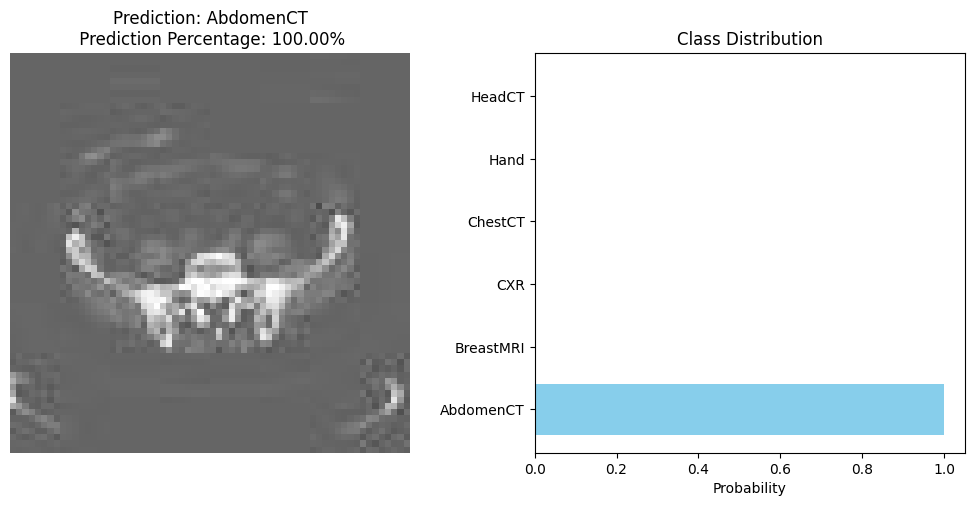

Predicting for class: BreastMRI


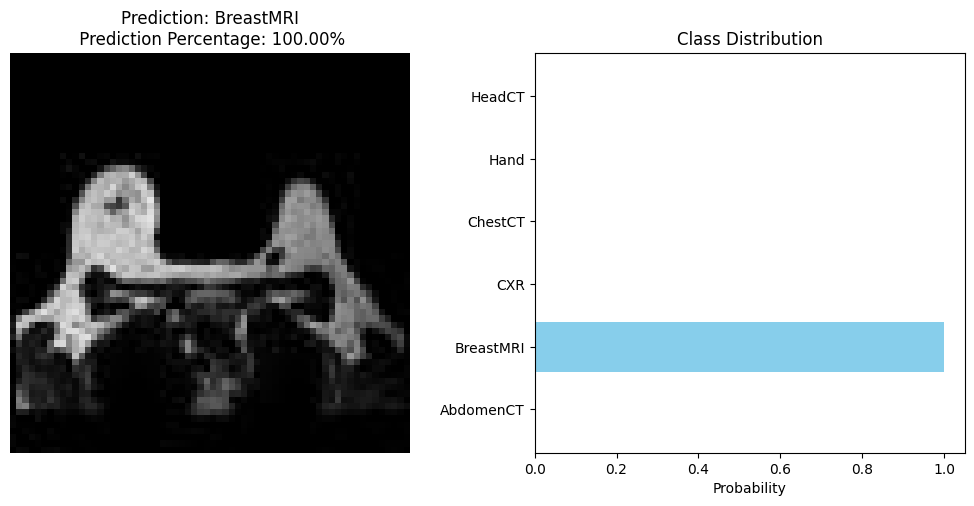

Predicting for class: CXR


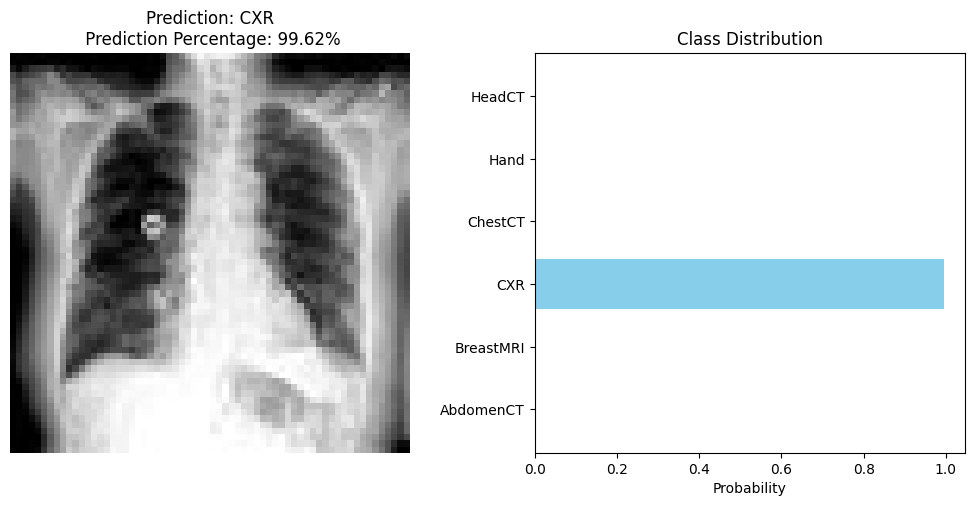

Predicting for class: ChestCT


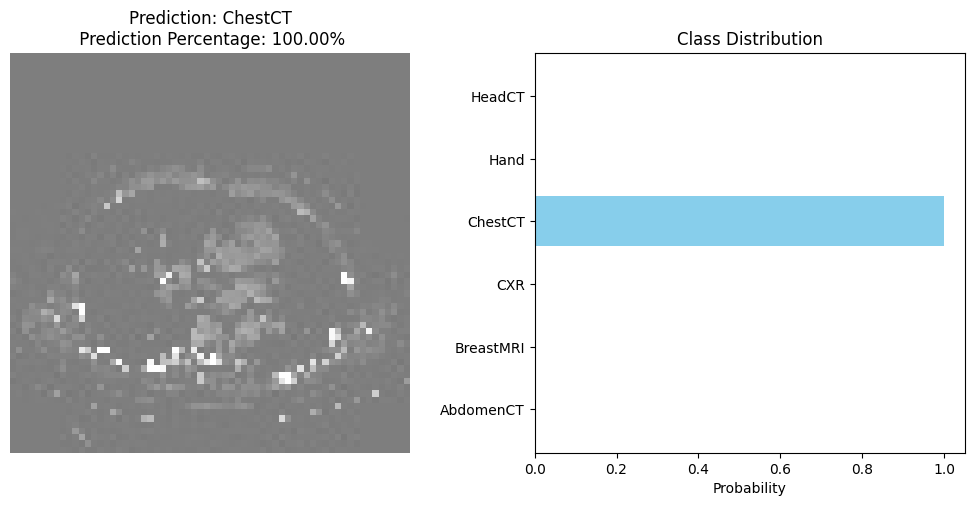

Predicting for class: Hand


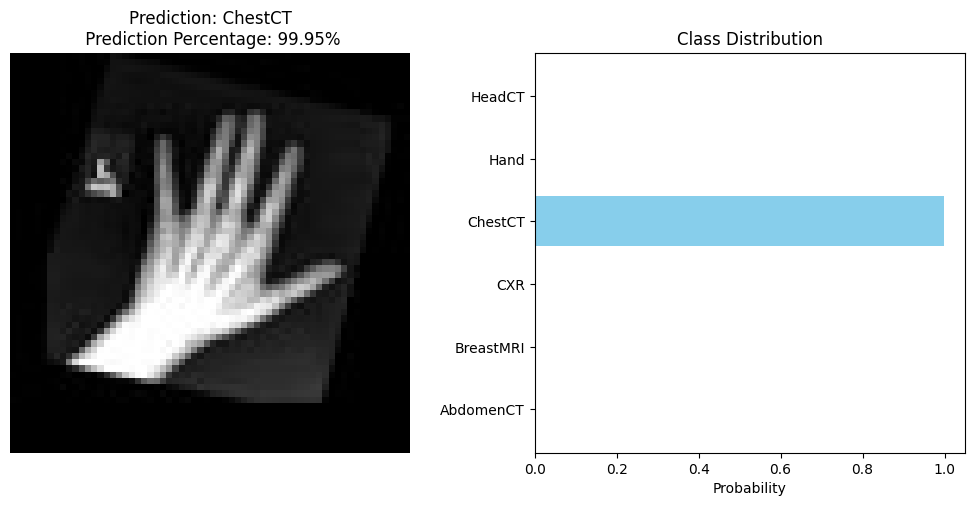

Predicting for class: HeadCT


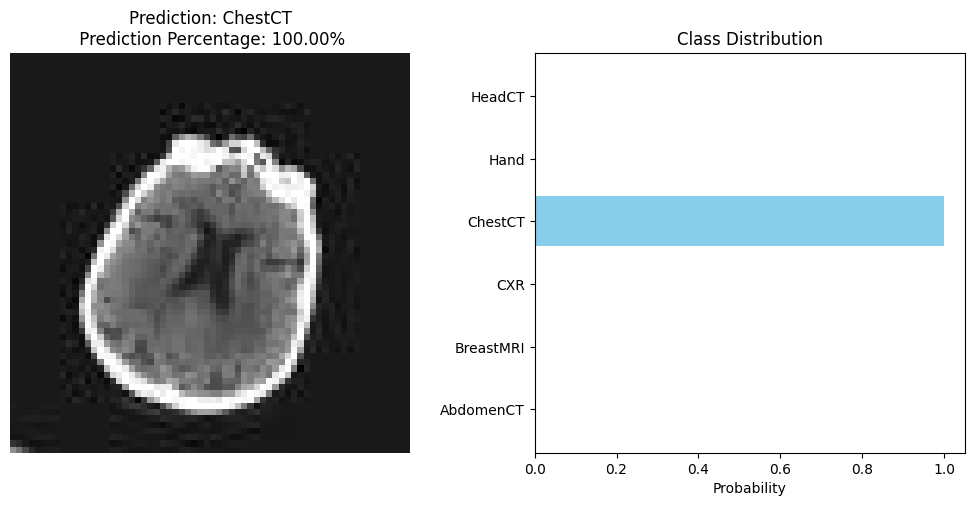

In [57]:
from tensorflow.keras.preprocessing import image

# Prediction System
def predict_image(img_path, model, classes):

    # Convert images into array and reshape and scale it
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Convert to tensor and move to device
    img_tensor = torch.tensor(img_array, dtype=torch.float32).to(device)
    img_tensor = img_tensor.permute(0, 3, 1, 2)

    img_tensor = img_tensor[:,0,:,:].unsqueeze(1)

    # Make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        predictions = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(predictions).item()
        predicted_proba = torch.max(predictions).item()

        predictions_cpu = predictions.cpu().numpy()

    # Visuaization
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Prediction: {classes[predicted_class]}\n Prediction Percentage: {predicted_proba:.2%}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.barh(classes, predictions_cpu[0], color='skyblue')
    plt.xlabel('Probability')
    plt.title('Class Distribution')
    plt.tight_layout()
    plt.show()


# Sample testing
classes=['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
img_path= [ '/content/AbdomenCT','/content/BreastMRI', '/content/CXR', '/content/ChestCT', '/content/Hand', '/content/HeadCT' ]

for class_name, image_dir in zip(classes, img_path):
  img_path= os.path.join(image_dir, os.listdir(image_dir)[7])
  print(f'Predicting for class: {class_name}')
  predict_image(img_path, model, classes)



